In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
from sklearn.calibration import calibration_curve

In [8]:
dataset = pd.read_csv('split_3.csv')
dataset

,Unnamed: 0,label,tweet
0,0,0,@user when a father is dysfunctional and is s...
1,1,0,@user @user thanks for #lyft credit i can't us...
2,2,0,bihday your majesty
3,3,0,#model i love u take with u all the time in ...
4,4,0,factsguide: society now #motivation
...,...,...,...
31957,31957,0,ate @user isz that youuu?ðððððð...
31958,31958,0,to see nina turner on the airwaves trying to...
31959,31959,0,listening to sad songs on a monday morning otw...
31960,31960,1,"@user #sikh #temple vandalised in in #calgary,..."


<AxesSubplot:>

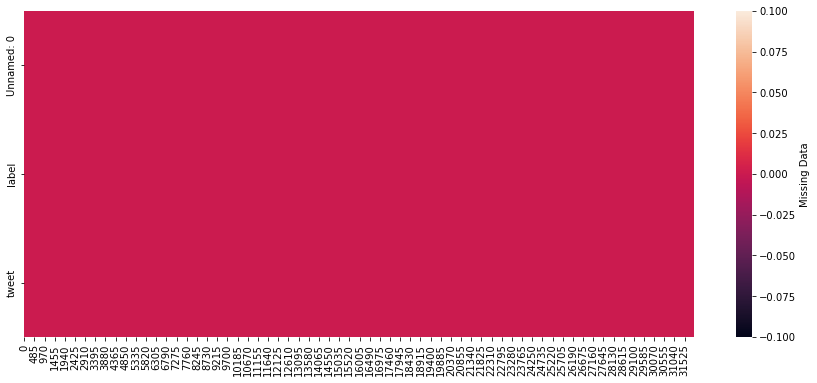

In [10]:
plt.figure(figsize=(15,6))
sns.heatmap(dataset.isnull().transpose(),cbar_kws={'label': 'Missing Data'})
#No missing values visible, Good data !

In [13]:
print(dataset[dataset['tweet'].isnull()].index)

Index([], dtype='int64')


In [14]:
X = dataset['tweet']
y = dataset['label']
X

0         @user when a father is dysfunctional and is s...
1        @user @user thanks for #lyft credit i can't us...
2                                      bihday your majesty
3        #model   i love u take with u all the time in ...
4                   factsguide: society now    #motivation
                               ...                        
31957    ate @user isz that youuu?ðððððð...
31958      to see nina turner on the airwaves trying to...
31959    listening to sad songs on a monday morning otw...
31960    @user #sikh #temple vandalised in in #calgary,...
31961                     thank you @user for you follow  
Name: tweet, Length: 31962, dtype: object

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y.values.reshape(-1,1), test_size=0.05, random_state=4)
len(X_train),len(X_test)

(30363, 1599)

In [28]:
max_features_values = [5000, 10000]

tfidf_vectorizer = TfidfVectorizer()
 
param_grid = {
    'max_features': max_features_values,
}

grid_search = GridSearchCV(tfidf_vectorizer, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_max_features = grid_search.best_params_['max_features']

print(f"Best max_features: {best_max_features}")

best_tfidf_vectorizer = grid_search.best_estimator_

/Users/yben409/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/yben409/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/yben409/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/yben409/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/yben409/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "/Users/yben409/opt/anaconda3/lib/python3

Best max_features: 5000


In [29]:
pickle.dump(best_tfidf_vectorizer, open('grid_search_5000_tfidf.pkl', 'wb'))

In [30]:
best_tfidf_vectorizer = pickle.load(open('grid_search_5000_tfidf.pkl', 'rb'))

In [31]:
X_train_tweets_tfidf = best_tfidf_vectorizer.transform(X_train)
X_test_tweets_tfidf = best_tfidf_vectorizer.transform(X_test)

num_train_samples, _ = X_train_tweets_tfidf.shape
num_test_samples, _ = X_test_tweets_tfidf.shape

print(f"Number of training samples: {num_train_samples}")
print(f"Number of test samples: {num_test_samples}")

Number of training samples: 30363
Number of test samples: 1599


In [32]:
# Convert your sparse TF-IDF matrices to dense numpy arrays
X_train_tweets_dense = X_train_tweets_tfidf.toarray()
X_test_tweets_dense = X_test_tweets_tfidf.toarray()

In [33]:
nb = GaussianNB()
nb2 = BernoulliNB()
nb3 = MultinomialNB()
VotingClassifiers = VotingClassifier(estimators=[('GaussianNB', nb),('BernoulliNB',nb2), ('MultinomialNB', nb3)], voting='soft')

VotingClassifiers.fit(X_train_tweets_dense, y_train)

/Users/yben409/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yben409/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


VotingClassifier(estimators=[('GaussianNB', GaussianNB()),
                             ('BernoulliNB', BernoulliNB()),
                             ('MultinomialNB', MultinomialNB())],
                 voting='soft')

In [34]:
print('Training score:', VotingClassifiers.score(X_train_tweets_dense, y_train))
print('Testing score:', VotingClassifiers.score(X_test_tweets_dense, y_test))

Training score: 0.9688436584000264
Testing score: 0.9530956848030019


In [35]:
import pickle
pickle.dump(VotingClassifiers, open('Voting_classifier_3.pkl', 'wb'))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=5, random_state=42)
rf_classifier.fit(X_train_tweets_dense, y_train)

In [ ]:
print('Training score:', rf_classifier.score(X_train_tweets_dense, y_train))
print('Testing score:', rf_classifier.score(X_test_tweets_dense, y_test))

In [ ]:
import xgboost as xgb

xgb_classifier = xgb.XGBClassifier(n_estimators=5, random_state=42)
y_train = np.where(y_train == 0, 0, 1)
xgb_classifier.fit(X_train_tweets_dense, y_train)

In [ ]:
print('Training score:', xgb_classifier.score(X_train_tweets_dense, y_train))
print('Testing score:', xgb_classifier.score(X_test_tweets_dense, y_test))

In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

clf = HistGradientBoostingClassifier()
clf.fit(X_train_tweets_dense, y_train)

In [ ]:
print('Training score:', clf.score(X_train_tweets_dense, y_train))
print('Testing score:', clf.score(X_test_tweets_dense, y_test))